In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import cv2
from PIL import Image
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch.nn import functional as F
from torch import optim
import mlflow
import json
import hydra
from omegaconf import DictConfig, OmegaConf
import albumentations as A
import time
import datetime

from utils import *
from implementations import *

In [2]:
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, "../data_NuVAT/pancreas")
data = ["Case001-1", "Case001-2", "Case002-1", "Case003-2", "Case004-1", "Case006-1"]


In [3]:
SegClasses = json.load(open("./SegClasses.json", "r"))

In [4]:
used_organ = ["pancreas"]

In [5]:
train_data = data[1:]
valid_data = data[:1]
test_data = data[:1]

In [6]:
train_used_data = make_used_data(data_dir, train_data)
valid_used_data = make_used_data(data_dir, valid_data)
test_used_data = make_used_data(data_dir, test_data)

In [7]:
train_dataset = CustomDataset(data_dir, train_used_data, SegClasses, used_organ, common_transform=None, inference=False, instruments_dir=None, instruments_transform=None)
valid_dataset = CustomDataset(data_dir, valid_used_data, SegClasses, used_organ, common_transform=None, inference=False)
test_dataset = CustomDataset(data_dir, test_used_data, SegClasses, used_organ, common_transform=None, inference=False)

In [8]:
img, seg, img_path = train_dataset[0]

In [9]:
print(img_path)

/workdir/seg-laparo/../data_NuVAT/pancreas/Case001-2/label/label_000105.png


In [10]:
SegClasses

{'pancreas': {'label': 223}}

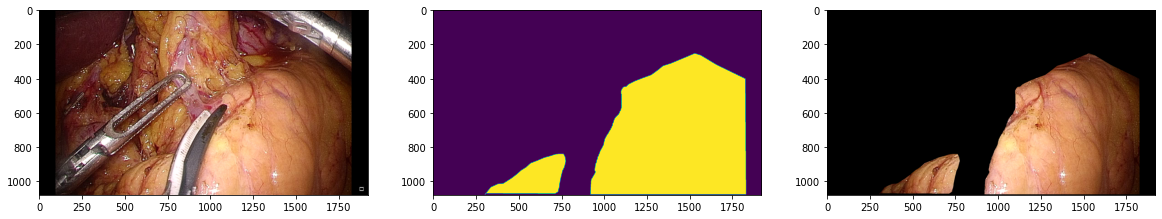

In [11]:
plot_image(img, seg, True)

In [12]:
img.shape

(1080, 1920, 3)

In [13]:
1080/1920 == 9/16

True

## Free

In [16]:
instruments_dir = "../data_NuVAT/pancreas/instruments"
# instruments_dir = "../data_NuVAT/pancreas/cutmixs"

In [17]:
train_dataset_orig = CustomDataset(data_dir, train_used_data, SegClasses, used_organ, inference=False)

# Inference
train_dataset = CustomDataset(data_dir, train_used_data, SegClasses, used_organ, common_transform=train_transform2, inference=False, instruments_dir=instruments_dir, instruments_transform=instruments_transform1)

# original
# train_dataset = CustomDataset(data_dir, train_used_data, SegClasses, used_organ, common_transform=None, inference=False)

# only instruments augmentation
# train_dataset = CustomDataset(data_dir, train_used_data, SegClasses, used_organ, common_transform=None, inference=False, instruments_dir=instruments_dir, instruments_transform=instruments_transform1)




/workdir/seg-laparo/../data_NuVAT/pancreas/Case001-2/label/label_000132.png
/workdir/seg-laparo/../data_NuVAT/pancreas/Case001-2/label/label_000132.png
/workdir/seg-laparo/../data_NuVAT/pancreas/Case001-2/label/label_000132.png
/workdir/seg-laparo/../data_NuVAT/pancreas/Case001-2/label/label_000132.png
/workdir/seg-laparo/../data_NuVAT/pancreas/Case001-2/label/label_000132.png


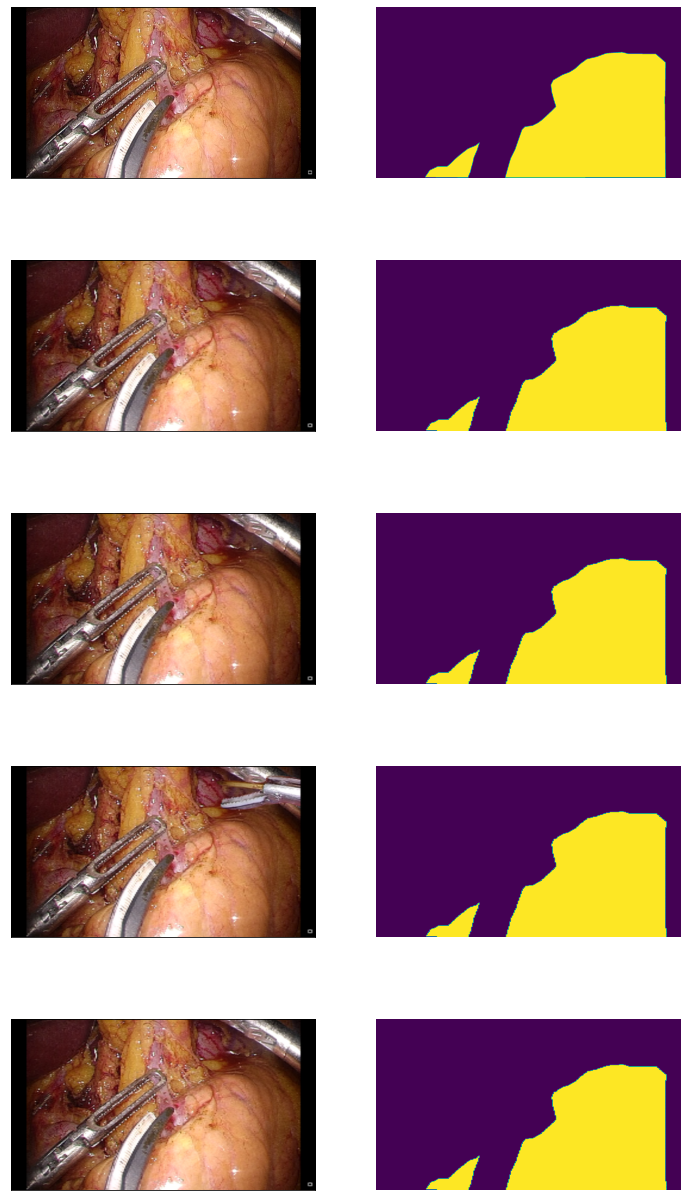

In [16]:
n = 5
j = 1
fig = plt.figure(figsize=(16*2 / 2 - 4, 9*n / 2))
for i in range(n):
    if i > 0:
        img, mask, Y_data_path = train_dataset[j]
    else:
        img, mask, _ = train_dataset_orig[j]
    print(_)
    ax1 = fig.add_subplot(n, 2, 2*i+1)
    ax1.imshow(resize9x16(img))
    ax1.set_xticks([])
    ax1.set_yticks([])
#     ax1.set_ylabel("{}".format(i), fontsize=15)
    ax2 = fig.add_subplot(n, 2, 2*i+2)
    ax2.imshow(resize9x16(mask))
    ax2.axis("off")
    if i == 0:
#         ax1.set_title("image", fontsize=15)
#         ax2.set_title("mask", fontsize=15)
        pass
# plt.savefig("./outputs/example2.png")
plt.show()

/workdir/seg-laparo/../data_NuVAT/pancreas/Case001-2/label/label_000132.png


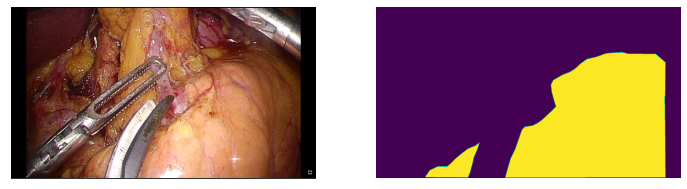

In [17]:
n = 1
j = 1
fig = plt.figure(figsize=(16*2 / 2 - 4, 9*n / 2))
for i in range(n):
    img, mask, _ = train_dataset_orig[j]
    print(_)
    ax1 = fig.add_subplot(n, 2, 2*i+1)
    ax1.imshow(resize9x16(img))
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2 = fig.add_subplot(n, 2, 2*i+2)
    ax2.imshow(resize9x16(mask))
    ax2.axis("off")
plt.savefig("./outputs/example_original.png")
plt.show()

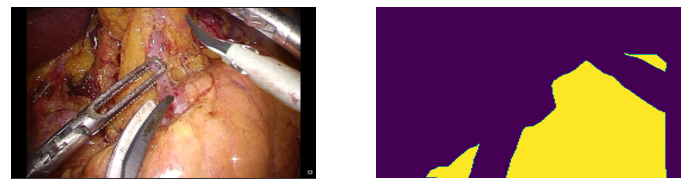

In [18]:
n = 1
j = 1
fig = plt.figure(figsize=(16*2 / 2 - 4, 9*n / 2))
for i in range(n):
    img, mask, Y_data_path = train_dataset[j]
    ax1 = fig.add_subplot(n, 2, 2*i+1)
    ax1.imshow(resize9x16(img))
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2 = fig.add_subplot(n, 2, 2*i+2)
    ax2.imshow(resize9x16(mask))
    ax2.axis("off")
plt.savefig("./outputs/example2.png")
plt.show()

In [19]:
a = [torch.from_numpy(np.random.rand(10, 3, 256, 256)).to("cuda:0").requires_grad_(True) for x in range(10)]
t = torch.stack(a).std(axis=0)
print(t.shape)

torch.Size([10, 3, 256, 256])


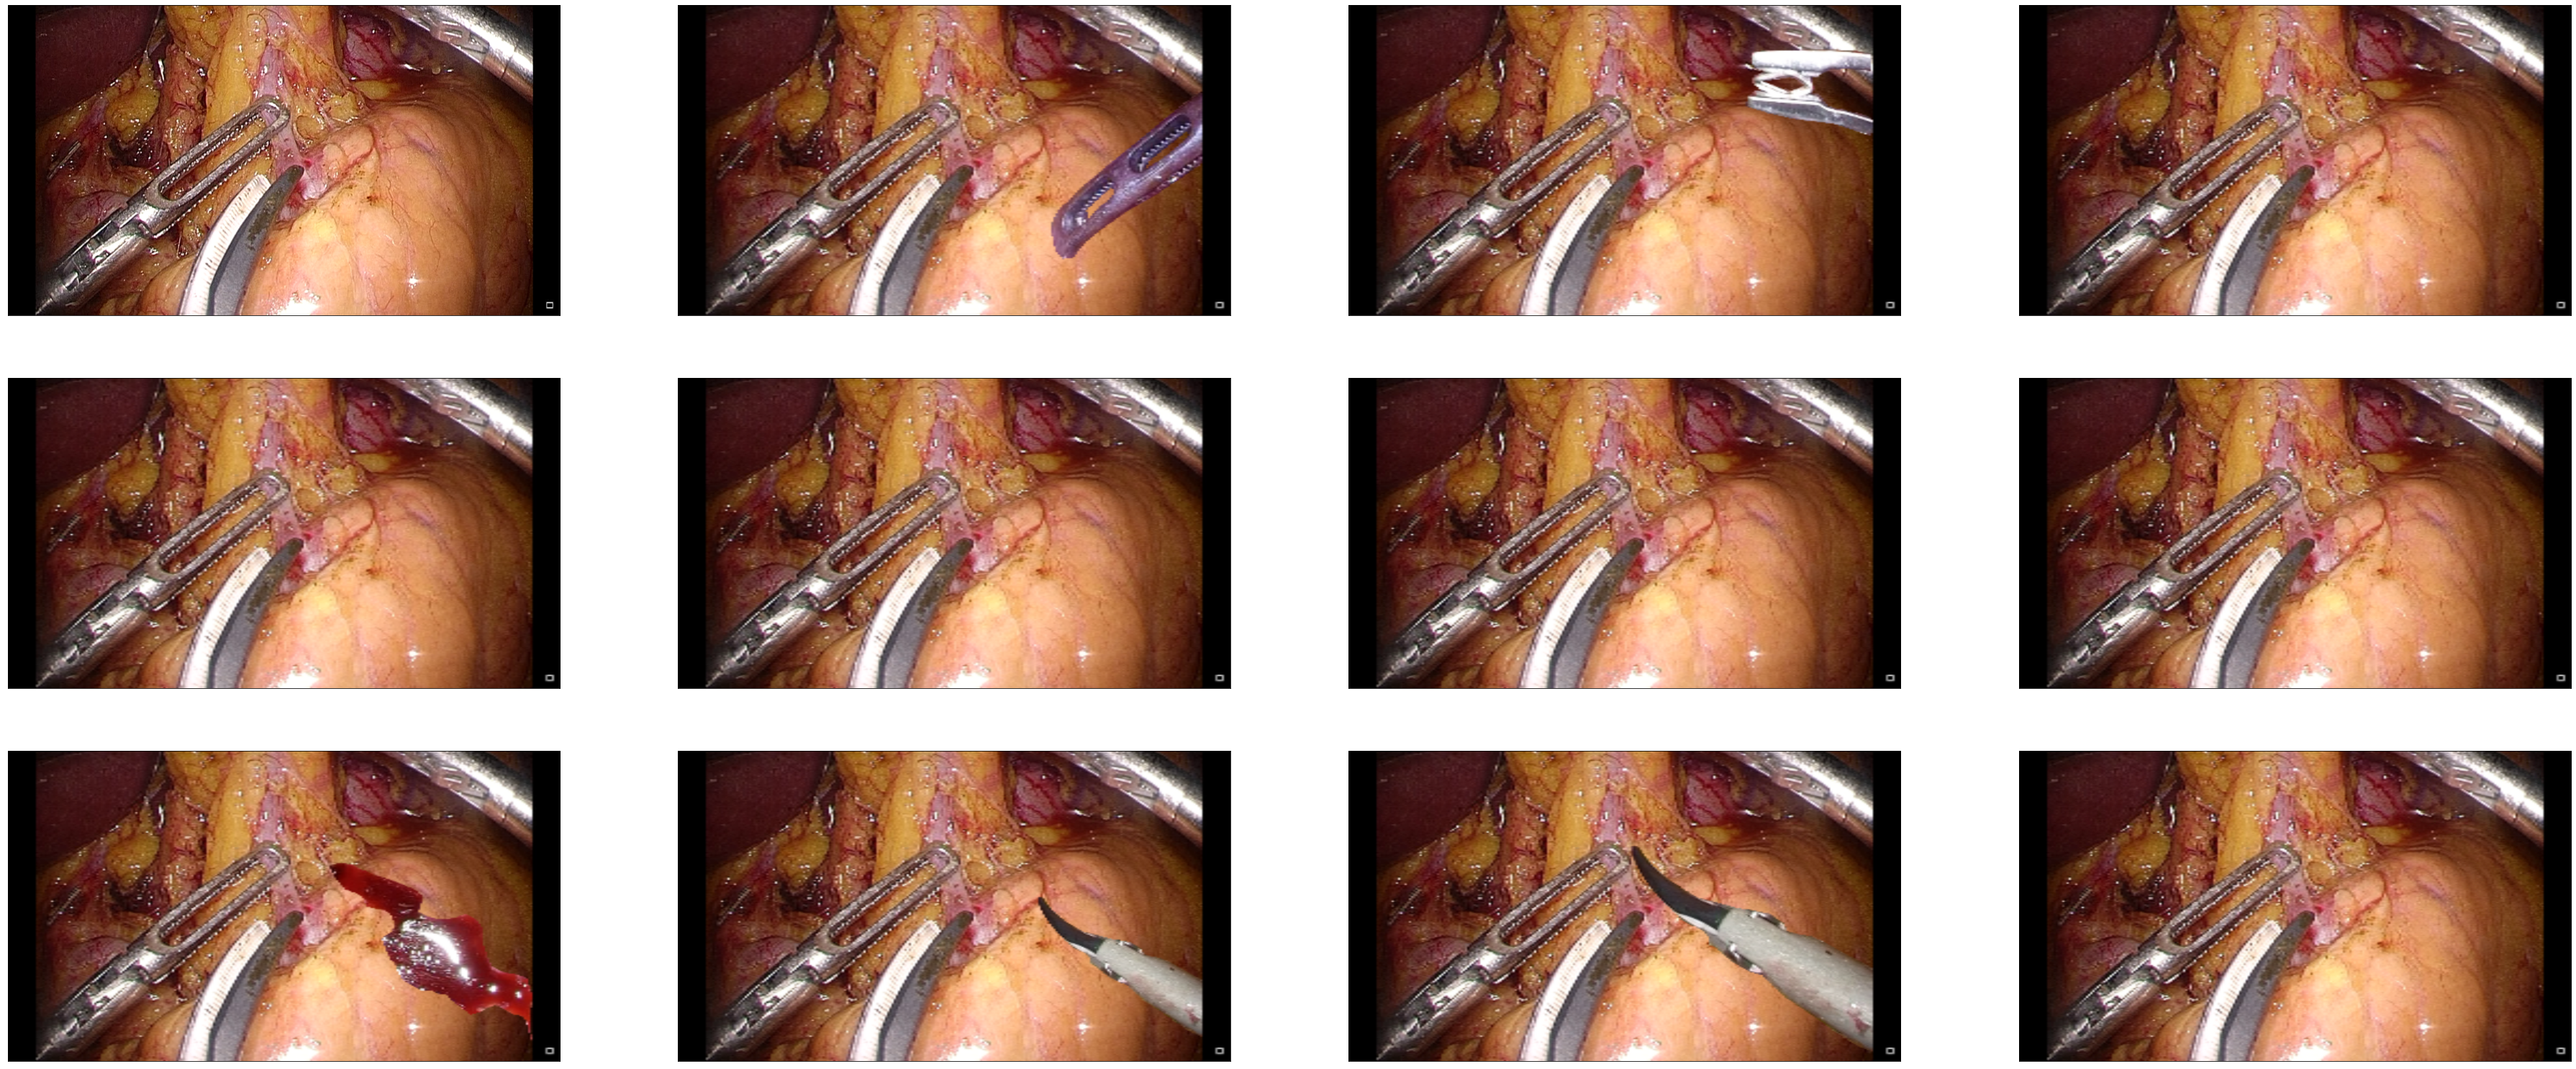

In [20]:
n = 12
r = 3
c = n // r
j = 1
fig = plt.figure(figsize=(16*c, 9*r))
for i in range(n):
    if i > 0:
        img, mask, _ = train_dataset[j]
    else:
        img, mask, _ = train_dataset_orig[j]
    ax1 = fig.add_subplot(r, c, i+1)
    ax1.imshow(resize9x16(img))
    ax1.set_xticks([])
    ax1.set_yticks([])

# plt.savefig("./outputs/example_dataaugmentation.png")
plt.show()

# Video

In [21]:
import cv2

cap = cv2.VideoCapture(os.path.join(current_dir, '../accVideo/Case008/case008_2.MTS'))
print(type(cap))
# <class 'cv2.VideoCapture'>

print(cap.isOpened())

<class 'cv2.VideoCapture'>
True


[h264 @ 0x917a3c0] reference picture missing during reorder
[h264 @ 0x917a3c0] Missing reference picture, default is 2147483647
[h264 @ 0x917a3c0] reference picture missing during reorder
[h264 @ 0x917a3c0] Missing reference picture, default is 2147483647


In [22]:
def frame2tensor(frame):
    frame = A.Resize(256, 256)(image=frame)["image"]
    tensor = transforms.ToTensor()(frame)
    return tensor

In [23]:
start_frame = 100
end_frame = 500
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

[h264 @ 0x90abf00] reference picture missing during reorder
[h264 @ 0x90abf00] Missing reference picture, default is 2147483647
[h264 @ 0x933bb00] reference picture missing during reorder
[h264 @ 0x933bb00] Missing reference picture, default is 2147483647
[h264 @ 0x6cb4980] reference picture missing during reorder
[h264 @ 0x6cb4980] Missing reference picture, default is 65546
[h264 @ 0x90abf00] reference picture missing during reorder
[h264 @ 0x90abf00] Missing reference picture, default is 2147483647
[h264 @ 0x933bb00] reference picture missing during reorder
[h264 @ 0x933bb00] Missing reference picture, default is 2147483647


True

In [24]:
# for i in range(end_frame - start_frame):
for i in range(3):
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    if not ret:
        raise ValueError("Problem with frame")
    print(cap.get(cv2.CAP_PROP_POS_FRAMES))
    
    tensor = frame2tensor(frame)
#     mask = model(tensor)


101.0
102.0
103.0


In [25]:
ret, frame = cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

In [26]:
frame.shape

(1080, 1440, 3)

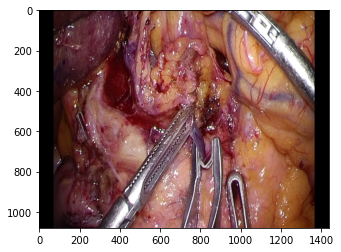

In [27]:
plt.imshow(frame)

In [18]:
import time

In [19]:
a = time.time()

In [20]:
b = time.time()

In [21]:
b - a

0.1615288257598877

In [22]:
"unet-01".find("unet-01")

0

In [23]:
VIDEO_PATH = '../../accVideo/Case001/case001_2.MTS'
VIDEO_NAME = VIDEO_PATH.split("/")[-1].split(".")[0]

In [24]:
VIDEO_NAME

'case001_2'

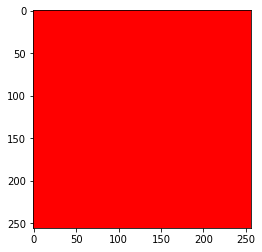

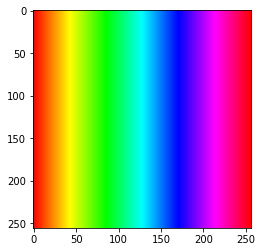

In [84]:
#base

a = np.zeros((256, 256, 3), dtype=np.uint8)
a[:, :, 0] = 255

plt.imshow(a)
plt.show()

b = cv2.cvtColor(a, cv2.COLOR_RGB2HSV_FULL)
# b = cv2.cvtColor(a, cv2.COLOR_RGB2HSV)
for i in range(256):
    b[:, i, 0] = i
c = cv2.cvtColor(b, cv2.COLOR_HSV2RGB_FULL)
# c = cv2.cvtColor(b, cv2.COLOR_HSV2RGB)

plt.imshow(c)
plt.show()

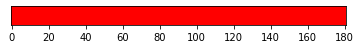

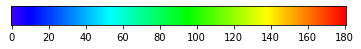

In [219]:
# color bar

u_max = 181
u_min = 0

a = np.zeros((10, u_max, 3), dtype=np.uint8)
a[:, :, 0] = 255

plt.imshow(a)
plt.xticks(np.arange(u_min, u_max+1, 20))
plt.yticks([])
plt.show()

b = cv2.cvtColor(a, cv2.COLOR_RGB2HSV_FULL)
for i in range(u_max):
    b[:, (u_max-1)-i, 0] = i
c = cv2.cvtColor(b, cv2.COLOR_HSV2RGB_FULL)
color_bar = np.copy(c)

plt.imshow(color_bar)
plt.xticks(np.arange(u_min, u_max, 20))
plt.yticks([])
plt.show()

In [42]:
class Pred2UncColor:
    def __init__(self, u_min=0, u_max=181):
        a = np.zeros((40, u_max, 3), dtype=np.uint8)
        a[:, :, 0] = 255
        b = cv2.cvtColor(a, cv2.COLOR_RGB2HSV_FULL)
        for i in range(u_max):
            b[:, (u_max-1)-i, 0] = i
        c = cv2.cvtColor(b, cv2.COLOR_HSV2RGB_FULL)
        self.u_max = u_max
        self.u_min = u_min
        self.color_bar = np.copy(c)
        
    def viz_bar(self):
        plt.imshow(self.color_bar)
        plt.xticks(np.arange(self.u_min, self.u_max, (self.u_max-1) / 5), [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        plt.yticks([])
        plt.tick_params(labelsize=30)
        plt.savefig("results/color_bar.pdf")
        plt.show()
        
    def pred2color(self, pred):
        u = np.around(pred * (self.u_max-1)).astype(np.int)
        c = self.color_bar[0, u, :]
        return c

In [43]:
np.arange(0.0, 1.01, 0.2)

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

In [44]:
puc = Pred2UncColor()

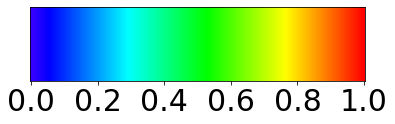

In [45]:
puc.viz_bar()

In [228]:
pred = np.concatenate([np.random.rand(128, 256), np.zeros((128, 256))])

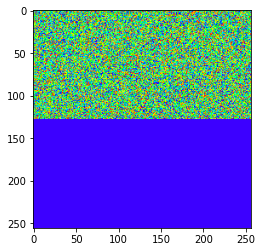

In [229]:
plt.imshow(puc.pred2color(pred))

In [166]:
pred2uncertainty(pred)

[[0.12670622 0.17344339 0.97630758 ... 0.17890987 0.46301949 0.61231233]
 [0.62308919 0.26283564 0.34262515 ... 0.91088897 0.70845578 0.37508894]
 [0.09471872 0.86022198 0.416727   ... 0.20544664 0.57501438 0.93556794]
 ...
 [0.5502251  0.77233538 0.5957805  ... 0.87386839 0.14698079 0.48440974]
 [0.2383138  0.36603929 0.56364368 ... 0.6903438  0.14129983 0.50819059]
 [0.74733597 0.61907526 0.21502681 ... 0.23436962 0.67334138 0.53133047]]


In [31]:
pred = np.random.rand(256, 256)

In [32]:
pred2 = 75 + (pred - 0.5) * (2 * 40)

In [33]:
pred2.min(), pred2.max()

(35.00042017762272, 114.9991520241027)

In [34]:
preds = [torch.from_numpy(np.random.randint(2, size=(10, 256, 256, 3))) for n in range(20)]

In [35]:
torch.cat(preds).shape

torch.Size([200, 256, 256, 3])

In [36]:
torch.cat(preds).size()

torch.Size([200, 256, 256, 3])

In [37]:
a = torch.from_numpy(np.random.randint(2, size=(10, 256, 256, 3)))

In [38]:
a.median(axis=0)

torch.return_types.median(
values=tensor([[[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0],
         ...,
         [0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 1],
         [0, 1, 0],
         [0, 0, 1],
         ...,
         [0, 0, 1],
         [0, 0, 0],
         [1, 1, 0]],

        [[0, 1, 0],
         [1, 0, 0],
         [0, 1, 0],
         ...,
         [0, 0, 0],
         [1, 0, 1],
         [0, 1, 0]],

        ...,

        [[0, 1, 0],
         [0, 1, 1],
         [0, 1, 0],
         ...,
         [0, 0, 0],
         [1, 0, 0],
         [1, 1, 1]],

        [[0, 0, 0],
         [0, 1, 0],
         [0, 1, 0],
         ...,
         [0, 1, 0],
         [0, 1, 0],
         [1, 0, 0]],

        [[1, 0, 0],
         [1, 0, 1],
         [0, 1, 1],
         ...,
         [0, 1, 1],
         [1, 1, 0],
         [1, 0, 0]]]),
indices=tensor([[[7, 5, 7],
         [0, 7, 7],
         [8, 8, 5],
         ...,
         [9, 2, 9],
         [7, 7, 8],
         [6, 

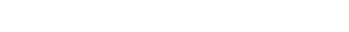

In [296]:
plt.imshow((np.ones((10, 181, 3)) * 255) .astype(np.uint8))
plt.xticks([])
plt.yticks([])
plt.axis('off')
# plt.savefig("test.png")

In [295]:
ls

README.md*         main.py*             run_mlflow.sh*
SegClasses.json*   main_evaluate.ipynb  utils/
conf/              make_video/          vizualize_for_thesis.ipynb
delete.csv         mlruns/              vizualize_images.ipynb
hydra_cfg.py       multirun/            vizualize_results.ipynb
implementations/   outputs/
initialize_dir.sh  results/
